# DEGs Classification

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten,Conv1D,MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import r2_score
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import os
import pickle

In [2]:
!nvidia-smi

Thu Aug 17 16:56:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA T600         On   | 00000000:17:00.0 Off |                  N/A |
| 38%   41C    P8    N/A /  41W |     20MiB /  3911MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA Graphics...  On   | 00000000:31:00.0 Off |                    0 |
| N/A   

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

### 导入数据并处理为可输入CNN的列表

In [4]:
import os
HOME = os.getcwd()
print(HOME)
file = 'maize_sorghum_DEGs_cds_2500_DL.csv'

/home/song/project/user/fanshaoqi/hackathon


In [5]:
# # 获取最长序列的长度
# def get_max_sequence_length(sequences):
#     return max(len(seq) for seq in sequences)

# # 填充序列到指定长度
# def pad_sequences_to_length(sequences):
#     padded_sequences = []
#     LEN_SEQ = get_max_sequence_length(sequences)
#     for seq in sequences:
#         if len(seq) < LEN_SEQ:
#             padding_length = LEN_SEQ - len(seq)
#             padded_seq = seq + 'N' * padding_length
#             padded_sequences.append(padded_seq)
#         else:
#             padded_sequences.append(seq)
#     return padded_sequences, LEN_SEQ

In [6]:
# 将DNA序列表示为数字
NTS=dict([("A",[1,0,0,0]),("C",[0,1,0,0]),("G",[0,0,1,0]),("T",[0,0,0,1]),("N",[0,0,0,0])]) 

def seq2nums(seq):
   return [NTS[x] for x in seq]

def set_barcode(species, treatment):  #总长为8的barcode
    str_1, str_2, barcode = '','',''  #定义空字符串，maize--ANNN, sorghum-TNNN
    
    if species=='maize':
        str_1 = 'ANNN'
    elif species =='sorghum':
        str_1 = 'TNNN'
    
    if treatment=='05h':
        str_2 = 'AANN'
    elif treatment=='1h':
        str_2 = 'ATNN'
    elif treatment=='3h':
        str_2 = 'ACNN'    
    elif treatment=='6h':
        str_2 = 'AGNN'    
    elif treatment=='16h':
        str_2 = 'TANN'    
    elif treatment=='24h':
        str_2 = 'TTNN'
    
    barcode = str(str_1) + str(str_2)
    
    return barcode
    
def create_training_data():
    training_data = [] 
    path = os.path.join(HOME,file)  #path to the gene_expr data
    df = pd.read_csv(path,sep=',',header=0,index_col=None)
    df.dropna(inplace=True)     #扔掉na值
    print(file,'length:',len(df))
    
    seqs = []
    for index, row in df.iterrows():
        seq, species, treatment = row['seq'],row['species'],row['treatment']
        barcode = set_barcode(species, treatment)
        sequence = str(barcode) + str(seq)
        try:
            seq_nums = seq2nums(sequence)
            seqs.append(seq_nums)
        except:
            continue
        
    labels = [x for x in df.label] #单标签 
    
    seqs=np.array(seqs)
    labels=np.array(labels)
    
    labels = to_categorical(labels, num_classes=3)
    
    return seqs,labels


def get_random_seed():
    state = random.getstate()
    return state[1][0]

# train/test splitting
def split_trainNtest(random_seed=None):
    seqs,exprs = create_training_data()
    
    if random_seed is not None:
        random.seed(random_seed)
    
    datalen=len(seqs)

    train_indices=random.sample(range(datalen),int(datalen*0.8))
    test_indices=list(set(range(datalen))-set(train_indices))

    seqs_train=seqs[train_indices]
    seqs_test=seqs[test_indices]
    exprs_train=exprs[train_indices]
    exprs_test=exprs[test_indices]
    
    random_seed = get_random_seed()
    print(random_seed)
    
    return seqs_train,seqs_test,exprs_train,exprs_test,random_seed

# CNN

In [7]:
# 搭建模型结构
def build(nchannels,width,LEN_SEQ):
   model = Sequential()

   model.add(Conv1D(128,kernel_size=width,padding='same',activation='relu',input_shape=(LEN_SEQ,nchannels)))
   model.add(Conv1D(128,kernel_size=width,padding='same',activation='relu'))
   model.add(MaxPooling1D(pool_size=width,padding='same'))
   model.add(Dropout(0.1))

   model.add(Conv1D(128,kernel_size=6,padding='same',activation='relu'))
   model.add(Conv1D(128,kernel_size=6,padding='same',activation='relu'))
   model.add(MaxPooling1D(pool_size=6,padding='same'))
   model.add(Dropout(0.1))

   model.add(Conv1D(64,kernel_size=6,padding='same',activation='relu'))
   model.add(Conv1D(64,kernel_size=6,padding='same',activation='relu'))
   model.add(MaxPooling1D(pool_size=6,padding='same'))
   model.add(Dropout(0.1))

#    model.add(Conv1D(64,kernel_size=3,padding='same',activation='relu'))
#    model.add(Conv1D(64,kernel_size=3,padding='same',activation='relu'))
#    model.add(MaxPooling1D(pool_size=3,padding='same'))
#    model.add(Dropout(0.1))

   model.add(Flatten())
   model.add(Dense(64,activation='relu'))
   model.add(Dropout(0.1))
   model.add(Dense(32,activation='relu'))
   model.add(Dropout(0.1))
   model.add(Dense(32,activation='relu'))
#    model.add(Dense(6,activation='sigmoid'))
   model.add(Dense(3,activation='softmax'))
#    model.add(Dense(1))


   return model

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def train_model(nchannels,width,LEN_SEQ,random_seed=None):
    seqs_train,seqs_test,exprs_train,exprs_test,random_seed = split_trainNtest(random_seed)
    model = build(nchannels,width,LEN_SEQ)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy']) 
    callback=[EarlyStopping(monitor='loss',patience=10,verbose=0,restore_best_weights=True)]
    model.fit(x = seqs_train,
             y = exprs_train,
             validation_data = (seqs_test,exprs_test),
             batch_size=2048,
             epochs=100,
              verbose=1,
             callbacks=callback)    #earlystopping--patience
    return model,seqs_train,seqs_test,exprs_train,exprs_test

In [ ]:
model,seqs_train,seqs_test,exprs_train,exprs_test = train_model(nchannels=4,width=3,LEN_SEQ=2508)

maize_sorghum_DEGs_cds_2500_DL.csv length: 53578
760884974
Epoch 1/100
21/21 [==============================] - 271s 13s/step - loss: 1.0870 - accuracy: 0.3752 - val_loss: 1.0778 - val_accuracy: 0.3834
Epoch 2/100
21/21 [==============================] - 272s 13s/step - loss: 1.0735 - accuracy: 0.4008 - val_loss: 1.0713 - val_accuracy: 0.4133
Epoch 3/100
21/21 [==============================] - 291s 14s/step - loss: 1.0668 - accuracy: 0.4258 - val_loss: 1.0615 - val_accuracy: 0.4336
Epoch 4/100
21/21 [==============================] - 300s 14s/step - loss: 1.0635 - accuracy: 0.4302 - val_loss: 1.0565 - val_accuracy: 0.4365
Epoch 5/100
21/21 [==============================] - 298s 14s/step - loss: 1.0511 - accuracy: 0.4456 - val_loss: 0.9972 - val_accuracy: 0.4945
Epoch 6/100
21/21 [==============================] - 287s 14s/step - loss: 0.9784 - accuracy: 0.5019 - val_loss: 0.9528 - val_accuracy: 0.5209
Epoch 7/100
21/21 [==============================] - 284s 14s/step - loss: 0.9558 -

 8/21 [==========>...................] - ETA: 2:46 - loss: 0.2348 - accuracy: 0.9119

In [ ]:
model.summary()

In [ ]:
model.save('hackathon.h5')

# 基因表达量预测

In [11]:
# 获取真实及预测值
# seqs_train,seqs_test,expr_train,expr_test = split_trainNtest(part=part)
pred_exprs = model.predict(seqs_test)

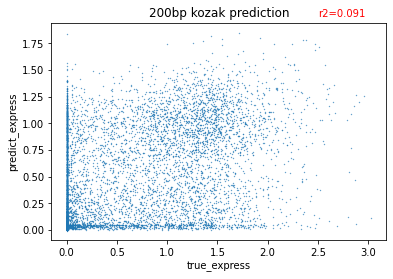

In [12]:
# 可视化
score = round(r2_score(exprs_test,pred_exprs),3)

plt.scatter(exprs_test,pred_exprs,s=0.1)
plt.xlabel('true_express')
plt.ylabel('predict_express')
plt.title(f'{LEN_SEQS[part-1]}bp kozak prediction')
plt.text(2.5,2,f'r2={score}',c='red')
plt.show()